In [ ]:
import torch
import torch.nn as nn
import timm
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

# SETUP, DATESET LOADING
BATCH_SIZE = 64
IMG_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform for Fine-Tuning (Same as pre-training, also add Flip for augmentation)
transform_ft = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Labeled Data (Train split = 5000 images)
train_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform_ft)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# Load Test Data (Test split = 8000 images)
test_set = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform_ft)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# MODEL WRAPPER
class FineTuneViT(nn.Module):
    def __init__(self, num_classes=10, pretrained_path=None):
        super().__init__()
        # Load standard ViT structure
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)

        
        if pretrained_path:
            # LOAD SSL WEIGHTS
            print(f"Loading Pre-trained MAE weights from {pretrained_path}")
            checkpoint = torch.load(pretrained_path)
            
            # We must filter out the 'head' weights because MAE had no classifier head
            # The checkpoint keys might match exactly if we saved model.vit.state_dict()
            msg = self.vit.load_state_dict(checkpoint, strict=False)
            print(f"Pre-trained weights loaded. Missing keys: {msg.missing_keys}")
        else:
            print("Initializing Random Weights (Baseline)")

    def forward(self, x):
        return self.vit(x)


def train_and_evaluate(model_name, train_loader, test_loader, pretrained_path=None, epochs=5):
    print(f"\n--- Training {model_name} ---")
    
    # Initialize Model
    model = FineTuneViT(num_classes=10, pretrained_path=pretrained_path).to(device)

    # Load the saved fine-tuned Vit model
    # model = FineTuneViT(num_classes=10)
    # model.vit.load_state_dict(torch.load("mae_finetuned_vit_stl10.pth"))
    # model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
    
    # Dictionaries to store history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'test_acc': [],
        'test_f1': []
    }
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Calculate Training Accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train 
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        
        # VALIDATION
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = total_val_loss / len(test_loader)
        history['val_loss'].append(avg_val_loss)
        
        epoch_acc = accuracy_score(all_labels, all_preds) * 100
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted') * 100
        
        history['test_acc'].append(epoch_acc)
        history['test_f1'].append(epoch_f1)
        
        print(f"Epoch {epoch+1}: Train Acc {train_acc:.2f}% | Val Acc {epoch_acc:.2f}% | Val Loss {avg_val_loss:.4f}")
        
    return model, history


# Train MAE Model
mae_model, mae_hist = train_and_evaluate(
    "MAE Fine-Tuned", 
    train_loader, 
    test_loader, 
    pretrained_path="mae_encoder_final.pth", 
    epochs=15
)
torch.save(mae_model.vit.state_dict(), "mae_finetuned_vit_stl10.pth")

# Train Baseline Model (Scratch)
baseline_model, base_hist = train_and_evaluate(
    "Baseline (Scratch)", 
    train_loader, 
    test_loader, 
    pretrained_path=None, 
    epochs=15
)

/home/neurolab/Desktop/Visual-Understanding/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Training MAE Fine-Tuned ---
Loading Pre-trained MAE weights from mae_encoder_final.pth
Missing keys (Expected, as we added a new head): ['head.weight', 'head.bias']
Epoch 1: Train Acc 43.46% | Val Acc 56.00% | Val Loss 1.1664
Epoch 2: Train Acc 64.04% | Val Acc 64.00% | Val Loss 0.9772
Epoch 3: Train Acc 72.98% | Val Acc 66.27% | Val Loss 0.9489
Epoch 4: Train Acc 78.96% | Val Acc 70.81% | Val Loss 0.8256
Epoch 5: Train Acc 83.58% | Val Acc 67.55% | Val Loss 0.9496
Epoch 6: Train Acc 86.98% | Val Acc 71.19% | Val Loss 0.8563
Epoch 7: Train Acc 90.78% | Val Acc 72.15% | Val Loss 0.8729
Epoch 8: Train Acc 91.98% | Val Acc 71.21% | Val Loss 0.9324
Epoch 9: Train Acc 94.18% | Val Acc 70.88% | Val Loss 0.9821
Epoch 10: Train Acc 94.54% | Val Acc 71.20% | Val Loss 0.9798
Epoch 11: Train Acc 96.62% | Val Acc 71.59% | Val Loss 1.0523
Epoch 12: Train Acc 96.32% | Val Acc 72.54% | Val Loss 1.0089
Epoch 13: Train Acc 96.92% | Val Acc 71.81% | Val Loss 1.0812
Epoch 14: Train Acc 95.46% | Val 

### Generate Graphs for Model Comparison

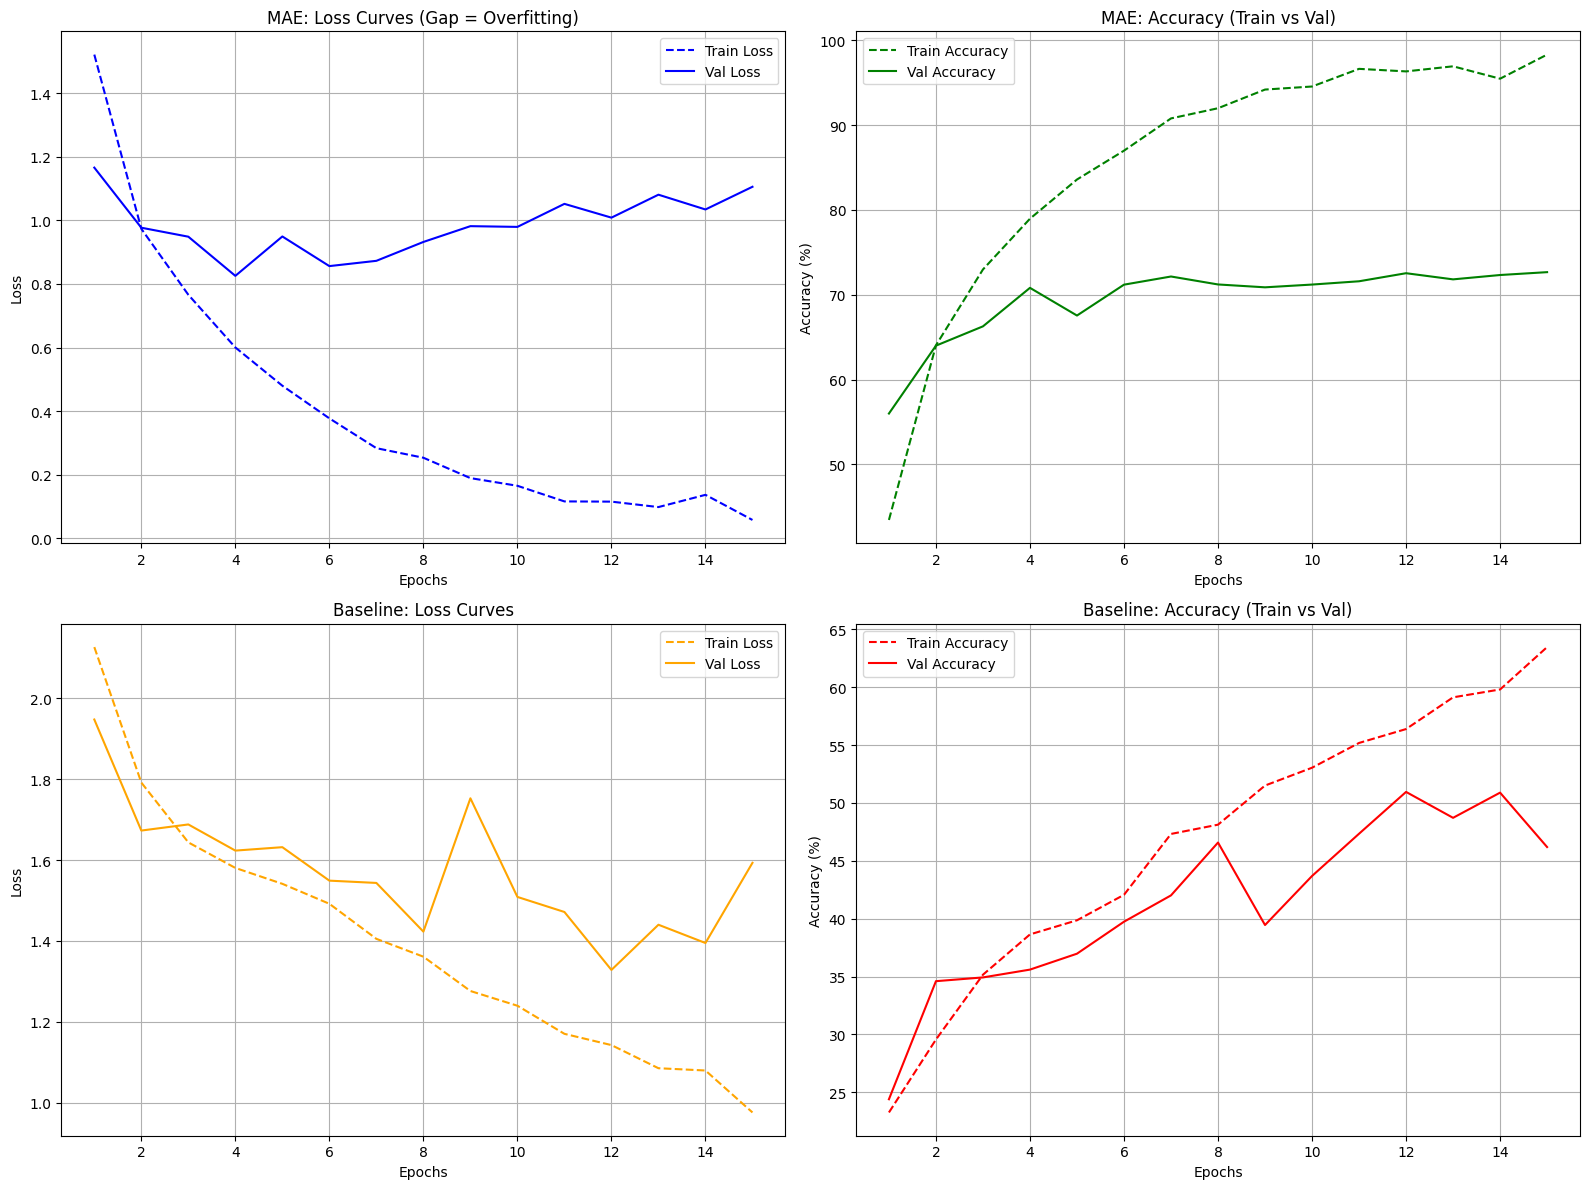

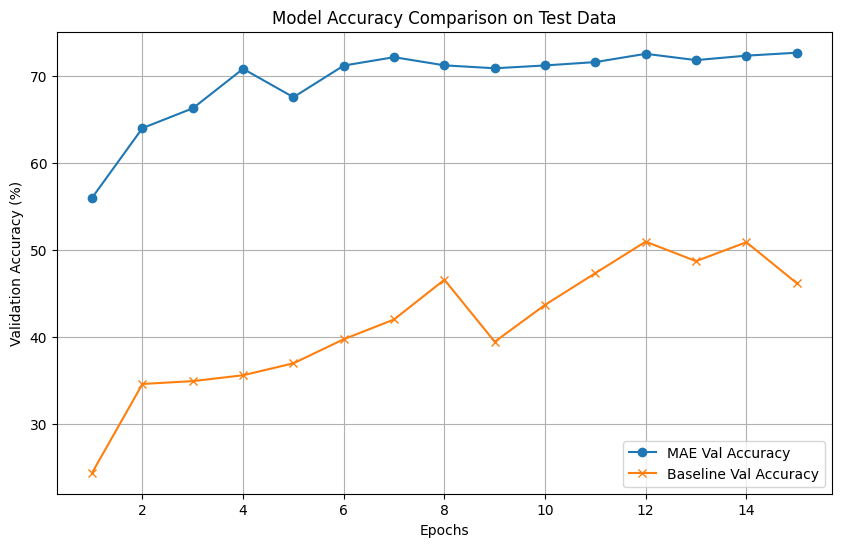

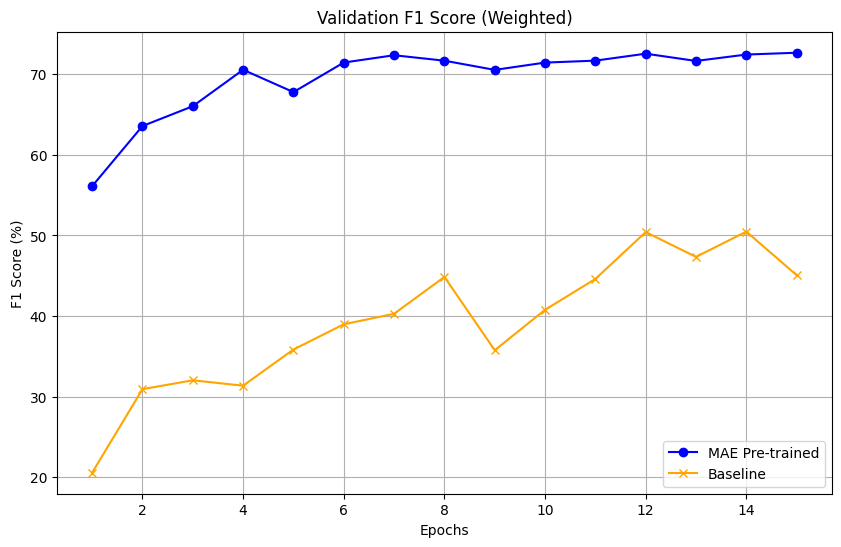

In [ ]:
epochs_range = range(1, len(mae_hist['train_loss']) + 1)

plt.figure(figsize=(16, 12))

# MAE MODEL ANALYSIS
plt.subplot(2, 2, 1)
plt.plot(epochs_range, mae_hist['train_loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(epochs_range, mae_hist['val_loss'], label='Val Loss', color='blue')
plt.title('MAE: Loss Curves (Gap = Overfitting)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs_range, mae_hist['train_acc'], label='Train Accuracy', color='green', linestyle='--')
plt.plot(epochs_range, mae_hist['test_acc'], label='Val Accuracy', color='green')
plt.title('MAE: Accuracy (Train vs Val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# BASELINE MODEL ANALYSIS
plt.subplot(2, 2, 3)
plt.plot(epochs_range, base_hist['train_loss'], label='Train Loss', color='orange', linestyle='--')
plt.plot(epochs_range, base_hist['val_loss'], label='Val Loss', color='orange')
plt.title('Baseline: Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs_range, base_hist['train_acc'], label='Train Accuracy', color='red', linestyle='--')
plt.plot(epochs_range, base_hist['test_acc'], label='Val Accuracy', color='red')
plt.title('Baseline: Accuracy (Train vs Val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Accuracy COMPARISON
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, mae_hist['test_acc'], label='MAE Val Accuracy', marker='o')
plt.plot(epochs_range, base_hist['test_acc'], label='Baseline Val Accuracy', marker='x')
plt.title('Model Accuracy Comparison on Test Data')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# F1-Score Comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, mae_hist['test_f1'], label='MAE Pre-trained', marker='o', color='blue')
plt.plot(epochs_range, base_hist['test_f1'], label='Baseline', marker='x', color='orange')
plt.title('Validation F1 Score (Weighted)')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (%)')
plt.legend()
plt.grid(True)
plt.show()

### Loss Comparison on Test Dataset

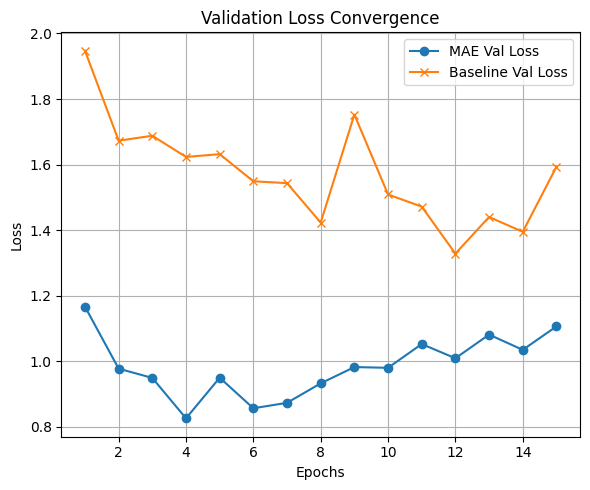

In [8]:
plt.figure(figsize=(6, 5))
plt.plot(epochs_range, mae_hist['val_loss'], label='MAE Val Loss', marker='o')
plt.plot(epochs_range, base_hist['val_loss'], label='Baseline Val Loss', marker='x')
plt.title('Validation Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('comparison_loss.png')

### Analyze Confusion Matrix

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_detailed(model, loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    # 1. Collect all predictions
    print("Evaluating...")
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # 2. Calculate Metrics
    # "weighted" accounts for any slight imbalance in the test set
    acc = accuracy_score(all_labels, all_preds)
    
    # 3. Print Detailed Report (Includes F1, Precision, Recall for every class)
    print(f"\nOverall Accuracy: {acc*100:.2f}%")
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # 4. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# STL-10 Class Names (Standard order)
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 
               'dog', 'horse', 'monkey', 'ship', 'truck']



### Confusion Matrix for Baseline Model (Not Pre-trained)

Evaluating...

Overall Accuracy: 46.79%

--- Classification Report ---
              precision    recall  f1-score   support

    airplane       0.73      0.65      0.69       800
        bird       0.57      0.34      0.42       800
         car       0.63      0.47      0.54       800
         cat       0.37      0.23      0.28       800
        deer       0.45      0.44      0.45       800
         dog       0.41      0.14      0.21       800
       horse       0.36      0.66      0.46       800
      monkey       0.50      0.40      0.44       800
        ship       0.70      0.53      0.60       800
       truck       0.34      0.84      0.49       800

    accuracy                           0.47      8000
   macro avg       0.51      0.47      0.46      8000
weighted avg       0.51      0.47      0.46      8000



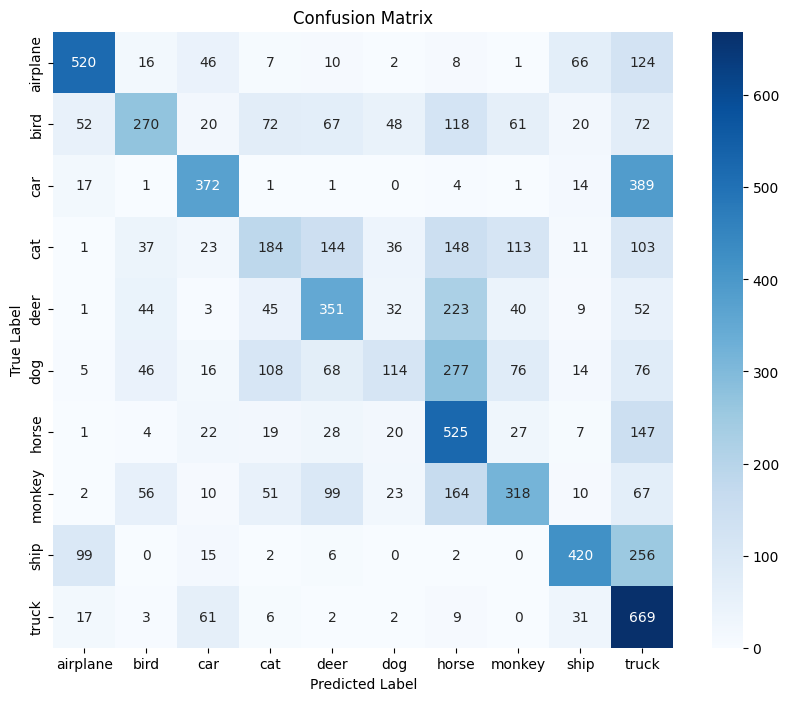

In [4]:
# Run the evaluation
evaluate_detailed(baseline_model, test_loader, device, class_names)

### Confusion Matrix for Pre-trained, Fine-tuned Model

Evaluating...

Overall Accuracy: 72.67%

--- Classification Report ---
              precision    recall  f1-score   support

    airplane       0.81      0.87      0.84       800
        bird       0.76      0.68      0.72       800
         car       0.90      0.80      0.85       800
         cat       0.54      0.66      0.59       800
        deer       0.77      0.57      0.65       800
         dog       0.57      0.51      0.54       800
       horse       0.73      0.74      0.74       800
      monkey       0.66      0.73      0.69       800
        ship       0.86      0.86      0.86       800
       truck       0.74      0.84      0.79       800

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000



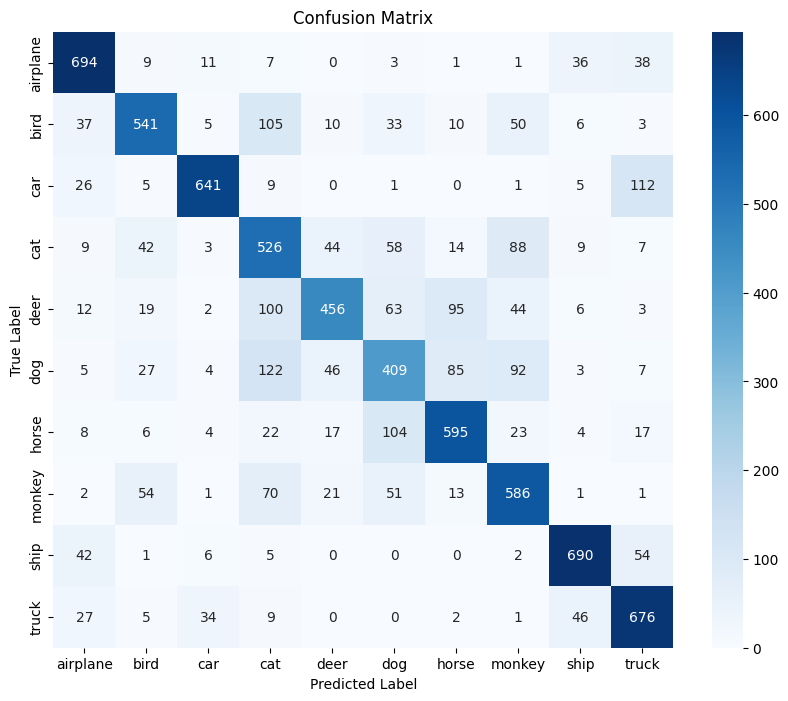

In [5]:
# Run the evaluation
evaluate_detailed(mae_model, test_loader, device, class_names)

Processing MAE Model...
Extracting features...
Processing Baseline Model...
Extracting features...
Running t-SNE...


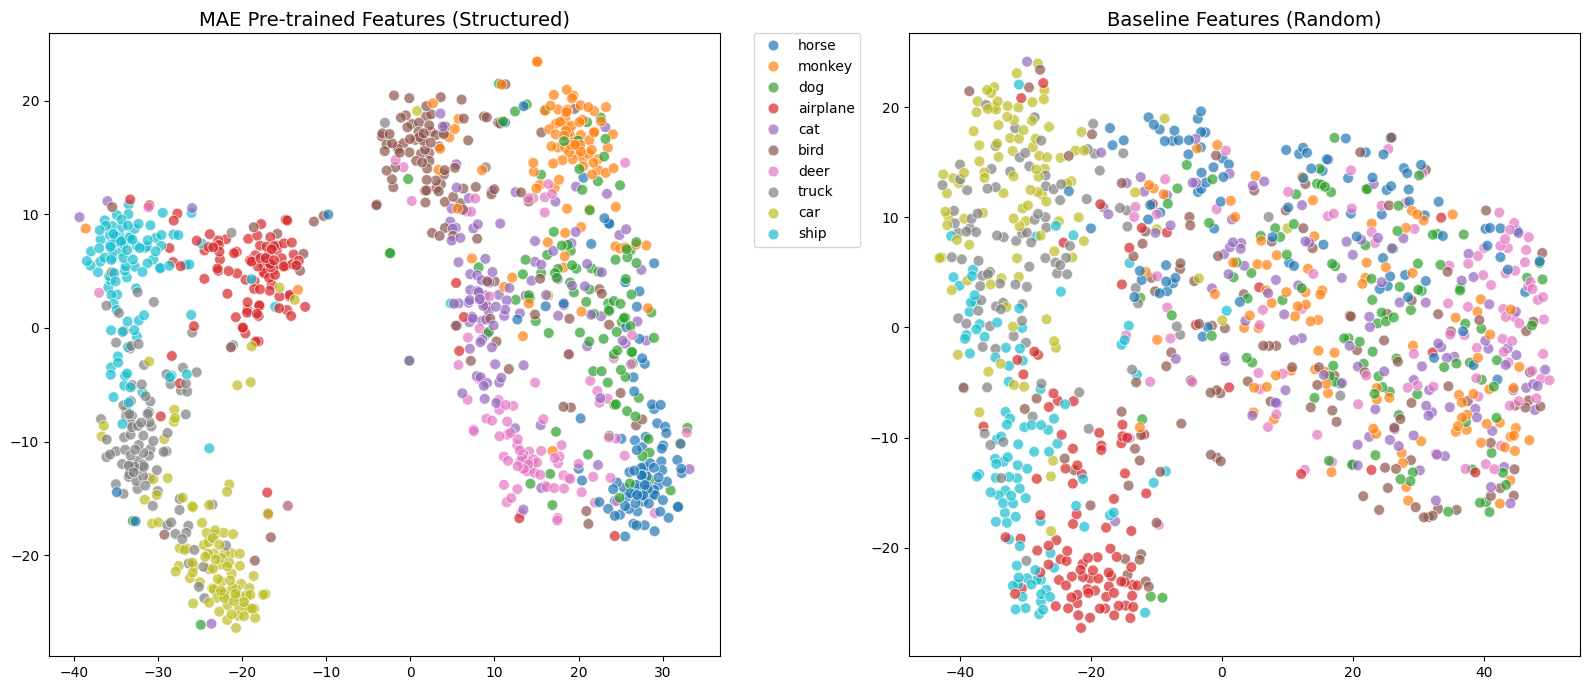

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def get_features(model, loader, device):
    model.eval()
    features = []
    labels_list = []
    
    print("Extracting features...")
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            
            # Extract features from the backbone
            # For TIMM models, forward_features returns (Batch, 197, 768)
            feats = model.vit.forward_features(imgs)
            
            # Take the CLS token (index 0) if the output is 3D
            if len(feats.shape) == 3:
                feats = feats[:, 0, :]
                
            features.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
            
            # Stop after ~1000 images to save time
            if len(features) * loader.batch_size > 1000:
                break
                
    features = np.concatenate(features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    return features, labels_list

# Extract Features
# Ensure mae_model and baseline_model are defined from previous cells
print("Processing MAE Model...")
mae_feats, mae_labels = get_features(mae_model, test_loader, device)

print("Processing Baseline Model...")
base_feats, base_labels = get_features(baseline_model, test_loader, device)

# Run t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30) 

mae_2d = tsne.fit_transform(mae_feats)
base_2d = tsne.fit_transform(base_feats)

# Plotting
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

plt.figure(figsize=(16, 7))

# Plot MAE
plt.subplot(1, 2, 1)
sns.scatterplot(x=mae_2d[:,0], y=mae_2d[:,1], hue=[class_names[i] for i in mae_labels], palette='tab10', s=60, alpha=0.7)
plt.title('MAE Pre-trained Features (Structured)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Plot Baseline
plt.subplot(1, 2, 2)
sns.scatterplot(x=base_2d[:,0], y=base_2d[:,1], hue=[class_names[i] for i in base_labels], palette='tab10', s=60, alpha=0.7)
plt.title('Baseline Features (Random)', fontsize=14)
plt.legend([],[], frameon=False) 

plt.tight_layout()
plt.show()